# Prostate image segmentation

We approached the task by implementing a model based on UNET. The 3d images were spliced across their depth and considered as independent samples.

The data  should be in its own folder and should have following structure
```bash
├── exercise4.ipynb
├── exercise_data
│   ├── project4_data
│   │   └── data
│   │       ├── test_images
│   │       ├── test_images_randomly_rotated
│   │       ├── test_labels
│   │       ├── test_labels_randomly_rotated
│   │       ├── train_images
│   │       └── train_labels
```

In [16]:
# source_path = 'data/'
source_path = 'exercise_data/project4_data/data/'
augmentation_factor = 1

## Data utilities

In [17]:
from skimage.transform import rotate, AffineTransform, warp
import numpy as np
import os
import cv2
import pandas as pd
import csv

def fix_shape(im):
    """
    Adapt image size to fit UNET
    """
    im = np.transpose(im, axes=[1, 2, 0])
    imr = cv2.resize(im, (256, 256), cv2.INTER_CUBIC)
    imr = np.transpose(imr, axes=(2, 0, 1))
    return imr

def disc_labels(labels):
    """
    One hot encoder
    """
    n_samples = labels.shape[0]
    height = labels.shape[1]
    width = labels.shape[2]
    n_labels = 3
    labels_disc = np.zeros(shape=(n_samples,height,width,n_labels))

    for samp in range(n_samples):
        for i in range(height):
            for j in range(width):
                pos = int(labels[samp,i,j])
                labels_disc[samp,i,j,pos] = 1
    return labels_disc



In [18]:
def get_data(source_path):
    train_images = []
    train_labels = []
    test_labels = []
    test_images = []
    test_labels_rot = []
    test_images_rot = []

    # train images
    for x in range(50):
        train_image_path = os.path.join(source_path, f'train_images/sample-{x}.npy')
        train_label_path = os.path.join(source_path, f'train_labels/sample-{x}.npy')
        mri_image = np.load(train_image_path)
        mri_label = np.load(train_label_path)

        train_images.append(mri_image)
        train_labels.append(mri_label)

    #test images
    for x in range(50,60):
        test_image_path = os.path.join(source_path, f'test_images/sample-{x}.npy')
        test_image_rot_path = os.path.join(source_path, f'test_images_randomly_rotated/sample-{x}.npy')
        test_label_path = os.path.join(source_path, f'test_labels/sample-{x}.npy')
        test_label_rot_path = os.path.join(source_path, f'test_labels_randomly_rotated/sample-{x}.npy')
        test_mri_image = np.load(test_image_path)
        test_mri_rot = np.load(test_image_rot_path)
        test_label = np.load(test_label_path)
        test_label_rot = np.load(test_label_rot_path)
        if x==52:
            test_mri_image = fix_shape(test_mri_image)
            test_mri_rot = fix_shape(test_mri_rot)
            test_label = fix_shape(test_label)
            test_label_rot = fix_shape(test_label_rot)

        test_images.append(test_mri_image)
        test_labels.append(test_label)
        test_images_rot.append(test_mri_rot)
        test_labels_rot.append(test_label_rot)

    return train_images, train_labels, \
           test_images, test_images_rot, \
           test_labels, test_labels_rot

We augmented the training dataset by applying random shearing and rotation to the images

In [19]:
def shear_img(img, label):
    shear_angle = np.random.random() - 0.5
    rot_angle = np.random.random() * 2 * np.pi
    transform = AffineTransform(shear=shear_angle, rotation=rot_angle)
    img = warp(img, transform)
    label = warp(img, transform)
    return img, label


def apply_transformation(X, Y, transform, subsample):
    new_X = []
    new_Y = []
    for img, label in zip(X, Y):
        new_X.append(img)
        new_Y.append(label)
        for _ in range(subsample):
            new_img, new_label = transform(img, label)
            new_X.append(new_img)
            new_Y.append(new_label)
    return new_X, new_Y


def augment_data(X, Y, augmentation_factor):
    np.random.seed(10)
    X, Y = apply_transformation(X, Y, shear_img, augmentation_factor)
    return X, Y

We also cropped each image in 9 overlapping 128x128 pieces. Resolution of labeling after reconstruction was performed taking the median prediction.

In [20]:
def sliding_window(image):
    images = []
    for y in range(3):
        for x in range(3):
            img = image[x*64:128+x*64,y*64:128+y*64]
            images.append(img)
    return images

def sub_images(images):
    sub_images = []
    for image in images:
        imgs = sliding_window(image)
        sub_images.append(imgs)
    sub_images = np.concatenate(sub_images)
    return sub_images

def reconstruct_image_sum(sub_images):
    image = np.zeros((256, 256, 3))
    for y in range(3):
        for x in range(3):
            idx = x + 3*y
            image[x*64: 128+x*64, y*64: 128+64*y,:] += sub_images[idx]
    return image

def reconstruct_image_median(sub_images):
    image = np.empty((256,256,3,9))
    image.fill(np.nan)
    for y in range(3):
        for x in range(3):
            idx = x + 3*y
            image[x*64: 128+x*64, y*64: 128+64*y, :, idx] = sub_images[idx]
    image = np.nanmedian(image, 3)
    return image

def reconstruct_array(array):
    images = []
    length = array.shape[0]
    splits = length //9
    for imgs in np.split(array, splits):
        img = reconstruct_image_median(imgs)
        images.append(img)
    return images

## Metric function

In [21]:
def getMetrics(gt,pred):

    n_labels = 3
    conf = np.zeros(shape=(n_labels,n_labels))

    assert len(gt.shape) ==3
    assert len(pred.shape) == 3

    n_samples = gt.shape[0]
    height = gt.shape[1]
    width = gt.shape[2]

    for sample in range(n_samples):
        for i in range(height):
            for j in range(width):
                obj_gt = gt[sample,i,j]
                obj_pd = pred[sample,i,j]
                conf[obj_gt,obj_pd] +=1
                conf[obj_pd, obj_gt] += 1

    op = np.trace(conf)/np.sum(conf)

    pc = np.sum(np.diag(conf)/np.sum(conf,axis=-1))/n_labels

    iou = np.sum(np.diag(conf)/(np.sum(conf,axis=-1) + np.sum(conf,axis=0) - np.diag(conf)))/n_labels

    return op,pc,iou

## Model

As already mentioned, the proposed model is based on UNET, the main difference being the inclusion of padding in the convolutional layers and allowing for variable depth. We experimented training with dice loss apart from cross entropy without noting great differences.

In [22]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os
import sys
import h5py
import numpy as np
import pandas as pd
import pickle


class UNet(object):
    def __init__(self,save_folder,input_shape=(400, 400, 3), epochs=30, verbose=1, batch_size=4, deepness=4):
        self.input_shape = input_shape
        self.epochs = epochs
        self.verbose = verbose
        self.batch_size = batch_size
        self.deepness = deepness
        self.save_folder = save_folder

    def create_model(self):
        self.input = keras.layers.Input(self.input_shape)
        self.skip = []
        inp = self.input
        # Convolution
        for x in range(self.deepness):
            filters = 2**(6 + x)
            skip, inp = self.conv_layer(filters, inp)
            self.skip.append(skip)

        # lowest layer
        conv1 = keras.layers.Conv2D(
            2**(6 + self.deepness), 3, activation='relu', padding='same')(inp)
        conv2 = keras.layers.Conv2D(
            2**(6 + self.deepness), 3, activation='relu', padding='same')(conv1)

        # Upsample and convolutions
        inp = conv2
        for x in range(self.deepness - 1, -1, -1):
            filters = 2**(6 + x)
            inp = self.upconv_layer(filters, inp, self.skip[x])

        output = keras.layers.Conv2D(3, 1, activation='softmax')(inp)
        model = keras.models.Model(inputs=self.input, outputs=output)
        model.summary()
        return model

    def conv_layer(self, filters, inp):
        conv1 = keras.layers.Conv2D(
            filters, 3, activation='relu', padding='same')(inp)
        conv2 = keras.layers.Conv2D(
            filters, 3, activation='relu', padding='same')(conv1)
        max_pool = keras.layers.MaxPool2D(2, strides=2)(conv2)
        return conv2, max_pool

    def upconv_layer(self, filters, inp, skip):
        up_conv = keras.layers.Conv2DTranspose(filters, 2, 2)(inp)
        up_shape = up_conv.shape.as_list()
        skip_shape = skip.shape.as_list()

        x_start = (skip_shape[1] - up_shape[1]) // 2
        y_start = (skip_shape[2] - up_shape[2]) // 2
        x_end = x_start + up_shape[1]
        y_end = y_start + up_shape[2]

        cut_skip = keras.layers.Lambda(
            lambda x: x[:, x_start:x_end, y_start: y_end, :])(skip)

        merge = keras.layers.concatenate([cut_skip, up_conv], axis=-1)
        conv1 = keras.layers.Conv2D(
            filters, 3, activation='relu', padding='same')(merge)
        conv2 = keras.layers.Conv2D(
            filters, 3, activation='relu', padding='same')(conv1)

        return conv2

    def fit(self, X, y, validation_data=None):
        early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=self.verbose)
        redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=self.verbose)
        self.model = self.create_model()
        self.model.compile(optimizer=keras.optimizers.Adam(),
                           loss='categorical_crossentropy', metrics=['accuracy'])
        if not validation_data:
            self.model.fit(x=X, y=y, batch_size=self.batch_size, verbose=self.verbose,
                        validation_split=0.1, epochs=self.epochs, callbacks=[early, redonplat])
        else:
            self.model.fit(x=X, y=y, batch_size=self.batch_size, verbose=self.verbose,
                        validation_data=validation_data, epochs=self.epochs, callbacks=[early, redonplat])

        if not os.path.exists(self.save_folder + 'checkpoint/'):
            os.makedirs(self.save_folder + 'checkpoint/')
        tf.keras.models.save_model(self.model,self.save_folder + 'checkpoint/Unet.h5')
        return self

    def predict(self, X):
        fileName = self.save_folder + 'checkpoint/Unet.h5'
        if not os.path.isfile(fileName):
            print("Model not found! Exiting ...")
            sys.exit(1)
        self.model = tf.keras.models.load_model(fileName)
        y_pred = self.model.predict(X, batch_size=self.batch_size)

        return y_pred

    def get_params(self, deep=True):
        return {
            'input_shape': self.input_shape,
            'epochs': self.epochs,
            'verbose': self.verbose,
            'batch_size': self.batch_size,
            'deepness': self.deepness
        }

    def set_params(self, **paramters):
        for paramter, value in paramters.items():
            setattr(self, paramter, value)

    def train(self, X_train, Y_train, validation_data=None):
        self.model = self.create_model()
        self.model.compile(optimizer=keras.optimizers.Adam(),
                           loss='binary_crossentropy', metrics=['accuracy'])
        if not validation_data:
            history = self.model.fit(x=X_train, y=Y_train, validation_split=0.1,
                        batch_size=self.batch_size, verbose=self.verbose, epochs=self.epochs)
        else:
            history = self.model.fit(x=X_train, y=Y_train, validation_data=validation_data,
                        batch_size=self.batch_size, verbose=self.verbose, epochs=self.epochs)

        training_loss = history.history['loss']
        val_loss = history.history['val_loss']

        train_curves = {'train': training_loss, 'val': val_loss}

        with open(self.save_folder + 'train_curves.pickle', 'wb') as f:
            pickle.dump(train_curves, f)

        if not os.path.exists(self.save_folder + 'checkpoint/'):
            os.makedirs(self.save_folder + 'checkpoint')

        fileName = self.save_folder + 'checkpoint/UNet.h5'
        tf.keras.models.save_model(self.model,filepath=fileName)

## Training

In [23]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

np.random.seed(0)

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

train_images, train_labels, test_images, test_images_rot, test_labels, test_labels_rot = get_data(source_path)

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

train_X, val_X, train_Y, val_Y = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42)

# train_X, train_Y = augment_data(train_X, train_Y, augmentation_factor)

sub_train_X = sub_images(train_X)
sub_train_Y = sub_images(train_Y)
sub_val_X = sub_images(val_X)
sub_val_Y = sub_images(val_Y)


sub_train_Y = disc_labels(sub_train_Y)
sub_val_Y = disc_labels(sub_val_Y)

sub_train_X = sub_train_X[..., np.newaxis]
sub_val_X = sub_val_X[..., np.newaxis]

sub_train_X, sub_train_Y = shuffle(sub_train_X, sub_train_Y)

unet = UNet('./', input_shape=(128, 128, 1),
                   epochs=100, deepness=3, verbose=1, batch_size=64)


Note: Because training times can be extensive, we included a already trained model in `checkpoint/Unet_sub_128x128.h5`. To run the trained model simply rename the model to `checkpoint/Unet.h5` and comment out the line below.

In [24]:
unet.fit(sub_train_X, sub_train_Y, (sub_val_X, sub_val_Y))

#### Quantitative evaluation

In [25]:
sub_pred_Y = unet.predict(sub_val_X)
pred_Y = reconstruct_array(sub_pred_Y)
pred_Y = np.array(pred_Y)
pred_Y = np.argmax(pred_Y, axis=-1).astype(int)

op, pc, iou = getMetrics(val_Y, pred_Y)
curr_metrics = {'OP': op, 'PC': pc, 'IoU': iou}

metrics = pd.DataFrame({}, columns=['OP', 'PC', 'IoU'])
metrics = metrics.append(curr_metrics, ignore_index=True)
print(metrics)

         OP        PC       IoU
0  0.978033  0.815895  0.711952


#### Qualitative evaluation

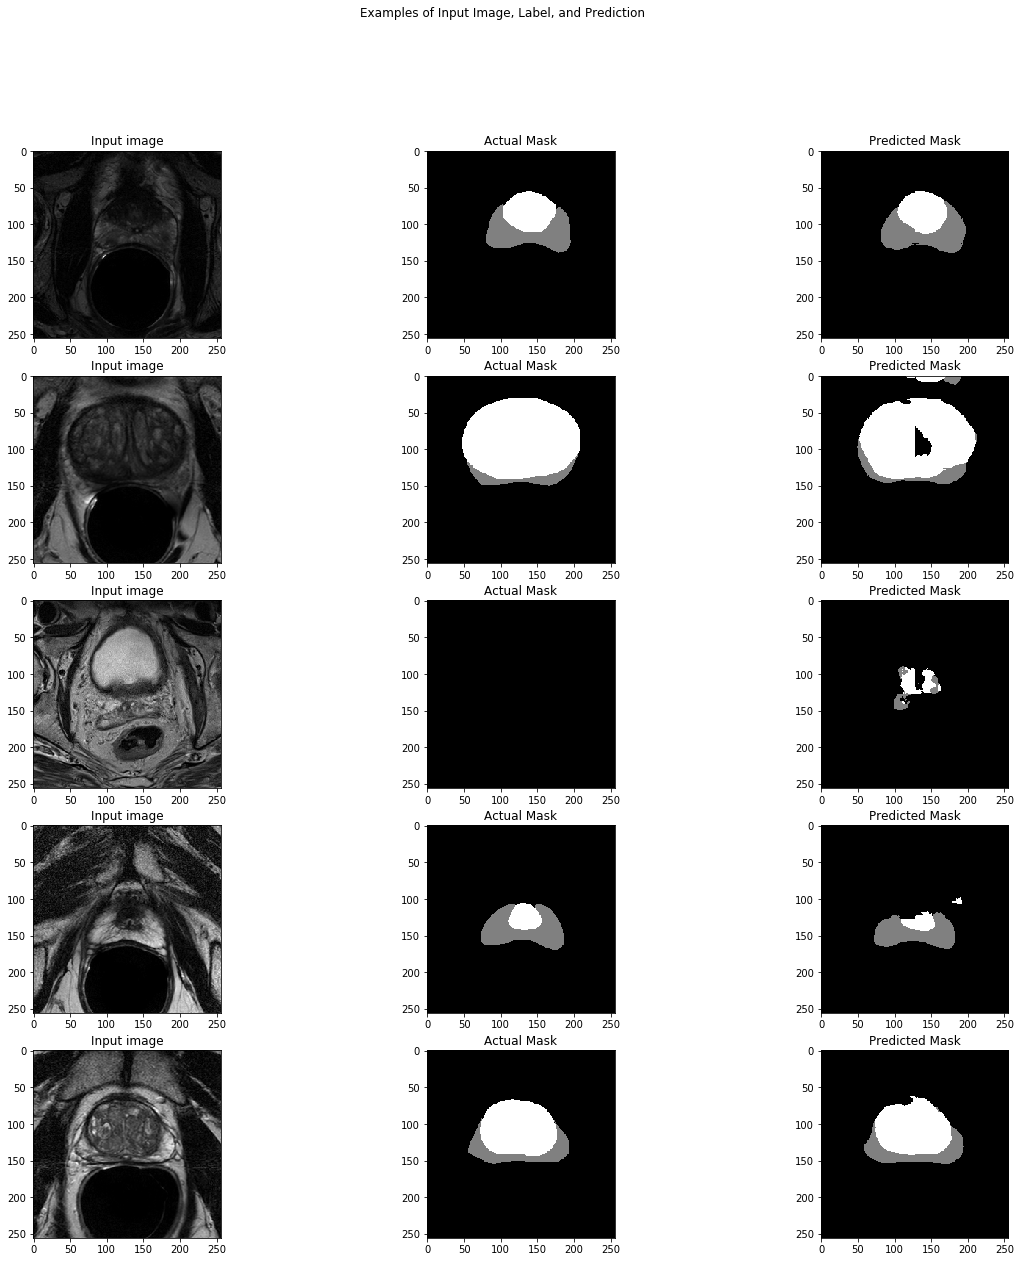

In [26]:
display_num = 5

r_choices = np.random.choice(val_Y.shape[0], display_num)
plt.figure(figsize=(20, 20))

for i in range(display_num):
  img_num = r_choices[i]
  
  plt.subplot(display_num, 3, 3 * i + 1)
  plt.imshow(val_X[img_num, :, :], cmap='gray')
  plt.title("Input image")
  
  plt.subplot(display_num, 3, 3 * i + 2)
  plt.imshow(val_Y[img_num, :, :], cmap='gray')
  plt.title("Actual Mask")
  
  plt.subplot(display_num, 3, 3 * i + 3)
  plt.imshow(pred_Y[img_num, :, :], cmap='gray')
  plt.title("Predicted Mask")

plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

## Test dataset

### Original dataset

In [27]:
#######################
###      TEST       ###
#######################
import csv

images_name = np.arange(50,60)
for i,test_im in enumerate(test_images):
    sub_test_im = sub_images(test_im)
    sub_test_im = sub_test_im[..., np.newaxis]
    sub_pred_im = unet.predict(sub_test_im)
    pred_im = reconstruct_array(sub_pred_im)
    pred_im = np.argmax(pred_im, axis=-1).astype(int)

    op, pc, iou = getMetrics(test_labels[i], pred_im)

    with open('test_images.csv', 'a') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['sample-{}'.format(images_name[i]), op,pc,iou])
    curr_metrics = {'OP': op, 'PC': pc, 'IoU': iou}
    metrics = metrics.append(curr_metrics, ignore_index=True)

In [28]:
test_images_csv = pd.read_csv('test_images.csv',delimiter=',',header=None)
test_images_csv.columns = ['Sample','OP','PC','IoU']
test_images_csv

,Sample,OP,PC,IoU
0,sample-50,0.918588,0.475337,0.396037
1,sample-51,0.978038,0.829014,0.726519
2,sample-52,0.967821,0.592615,0.527831
3,sample-53,0.949554,0.441459,0.385509
4,sample-54,0.966813,0.510909,0.444114
5,sample-55,0.972961,0.805127,0.699050
6,sample-56,0.957240,0.427571,0.379069
7,sample-57,0.967227,0.554965,0.463085
8,sample-58,0.945898,0.431828,0.377370
9,sample-59,0.968406,0.787294,0.674339


### Randomly rotated

The OOM problem should resolve itself when run on a gpu with enought memory

In [29]:
images_name = np.arange(50,60)
for i,rot_im in enumerate(test_images_rot):
    sub_test_rot = sub_images(rot_im)
    sub_test_rot = sub_test_rot[..., np.newaxis]
    sub_pred_rot = unet.predict(sub_test_rot)
    pred_rot = reconstruct_array(sub_pred_rot)
    pred_rot = np.argmax(pred_rot, axis=-1).astype(int)

    op, pc, iou = getMetrics(test_labels_rot[i], pred_rot)
    with open('test_images_randomly_rotated.csv', 'a') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['sample-{}'.format(images_name[i]), op,pc,iou])
    curr_metrics = {'OP': op, 'PC': pc, 'IoU': iou}
    metrics = metrics.append(curr_metrics, ignore_index=True)

ResourceExhaustedError: OOM when allocating tensor with shape[64,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node concatenate_2_31/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node conv2d_14_31/truediv}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
rot_images_csv = pd.read_csv('test_images_randomly_rotated.csv',delimiter=',',header=None)
rot_images_csv.columns = ['Sample','OP','PC','IoU']
rot_images_csv